# Feature Extraction

In [1]:
from utils.dataloader import *
from utils.sift import *
from utils.helper import strech_img, plot_img_and_hist, combine_labels
from utils.classifier import grid_search
import pandas as pd
from matplotlib import pyplot as plt
import cv2 as cv
from sklearn.model_selection import train_test_split
import pickle

In [2]:
RANDOM_STATE = 66

In [3]:
ROOT_PATH, img_dir, img_path, prob, types = load_data()
OUT_PATH = os.path.join(ROOT_PATH, 'out')
labels = combine_labels(prob, types)

print(img_dir)

print(len(img_path), 
      len(prob),
      len(types),
      len(labels))

[0 1 2 3 4 5 6 7] [588 117  56 313 920 178  50 402]
/Users/moooooo16/Documents/Computer Vision/Project/elpv/data
2624 2624 2624 2624


In [4]:
sift = SIFT(img_dir, img_path, processing_funcs=[strech_img])
kps, descriptor, empty_descriptor = sift.calculate_desriptor(mask=None)

Calculating descriptors: 100%|██████████| 2624/2624 [00:26<00:00, 100.32it/s]


# Challenges:

- Not all images have descriptor
- Not all descriptors are of same length

# Solution
- Since all images with no descriptor are dark images, we strech the image to increase the contrast

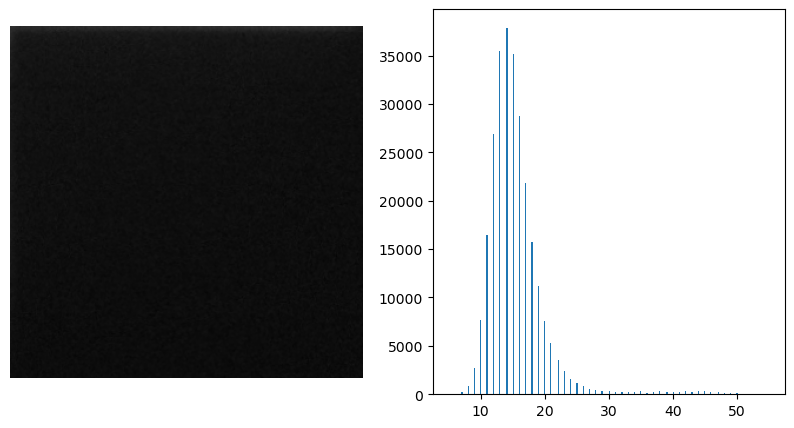

In [5]:

plot_img_and_hist(cv.imread(os.path.join(img_dir, img_path[1835])))

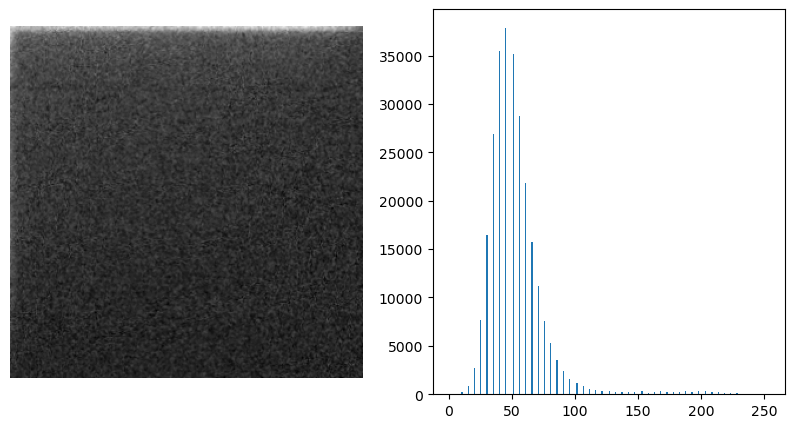

In [6]:

plot_img_and_hist(strech_img(cv.imread(os.path.join(img_dir, img_path[1835]))))

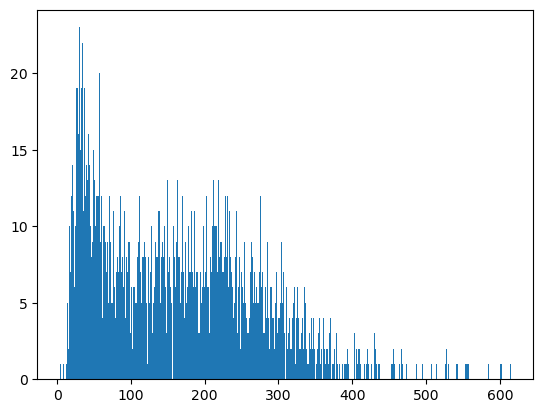

In [7]:

counts = [len(i) if i is not None else 0 for i in descriptor]

plt.hist(counts, bins = np.max(counts))
plt.show()

In [8]:

X_train, X_test, y_train, y_test = train_test_split(descriptor, labels, test_size=0.25, random_state=RANDOM_STATE, stratify= labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=RANDOM_STATE, stratify= y_train)

print(len(X_train), len(X_val), len(X_test))
print(len(y_train), len(y_val), len(y_test))

with open(os.path.join(OUT_PATH, 'sift_data.pkl'), 'wb') as f:
    pickle.dump([X_train, X_val, X_test, y_train, y_val, y_test], f)

1771 197 656
1771 197 656


In [9]:
# X_train, X_val, X_test, y_train, y_val, y_test = None, None, None, None, None, None

# with open (os.path.join(OUT_PATH, 'sift_data.pkl'), 'rb') as f:
#     X_train, X_val, X_test, y_train, y_val, y_test = pickle.load(f)
    
# sift = SIFT(img_dir, img_path, processing_funcs=[strech_img])

In [10]:
KS = [64, 128, 256, 384, 512, 640, 768, 896]

kmeans, features = sift.build_features(X_train, KS, 
                               state=RANDOM_STATE,
                               init = 'k-means++',
                               n_init=10,
                               max_iter=300,
                               tol=1e-4,)

with open(os.path.join(OUT_PATH, 'sift_features.pkl'), 'wb') as f:
    pickle.dump(features, f)
    
with open(os.path.join(OUT_PATH, 'sift_kmeans.pkl'), 'wb') as f:
    pickle.dump(kmeans, f)

Calculating kmeans for k = 64


Building histogram for k = 64: 100%|██████████| 1771/1771 [00:02<00:00, 756.36it/s]


Calculating kmeans for k = 128


Building histogram for k = 128: 100%|██████████| 1771/1771 [00:02<00:00, 733.50it/s]


Calculating kmeans for k = 256


Building histogram for k = 256: 100%|██████████| 1771/1771 [00:02<00:00, 712.30it/s]


Calculating kmeans for k = 384


Building histogram for k = 384: 100%|██████████| 1771/1771 [00:02<00:00, 659.64it/s]


Calculating kmeans for k = 512


Building histogram for k = 512: 100%|██████████| 1771/1771 [00:02<00:00, 624.72it/s]


Calculating kmeans for k = 640


Building histogram for k = 640: 100%|██████████| 1771/1771 [00:03<00:00, 572.32it/s]


Calculating kmeans for k = 768


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

knn_params = {
    'n_neighbors': [5,7,9,11,13, 15, 17, 19, 21],
}
svm_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
    
}

forest_params = {
    'n_estimators': [50, 100, 150, 200],
    'criterion': ('gini', 'entropy'),
    'max_depth':[None, 5, 10]
}
knn = KNeighborsClassifier(metric='euclidean')
svm = SVC(tol=1e-3)
forst = RandomForestClassifier()

params = [knn_params, svm_params, forest_params]
clfs = [knn, svm, forst]

results = []

In [ ]:
for k in KS:
    # Put clusters into bins, count number of descriptors in each bin
    hist_train = features[k]
    hist_val = sift.get_features(X_val, kmeans[k], k)
    
    # train a classifier use histogram

    for clf, param in zip(clfs, params):
    
        clf, pred, acc, conf_mat = grid_search(hist_train, y_train,
                                                hist_val, y_val,
                                                clf, param, 
                                                cv = 5, scoring='accuracy')
        

        results.append({'k': k, 
                        'clf': clf, 
                        'params': clf.get_params(), 
                        'pred': pred,
                        'acc': acc,
                        'conf_mat': conf_mat,})


the_best = max(results, key=lambda x: x['acc'])
print("------"*50)
print('Best K:', the_best['k'])
print('Average acc:', the_best['acc'])
print('Parameters:', the_best['params'])
print('Confusion matrix:\n', the_best['conf_mat'])


with open(os.path.join(OUT_PATH, 'sift_results.pkl'), 'wb') as f:
    pickle.dump(results, f)